In [3]:
from utils import *
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# 1.define MaLe_CoCo_TV imputation model
For simplicity and without losing generality, we add a scaled coefficient $\frac12$ and the optimization problem for MaLe-CoCo-TV becomes:
$$
    \min  \mathcal F_{TV} (\mathbf X,\mathbf C,\mathbf S,\mathbf Y)
    =\frac12\|\mathbf Y-\mathbf {CX}\|_F^2+\lambda\|\mathbf S\|_1+\frac \mu s tr \left(\mathbf Y\mathbf L\mathbf Y^\top \right)  +\beta_1\|\mathbf {YF}_1\|_1\\
     s.t.~\mathbf{W}\circ(\mathbf M-\mathbf Y)-\mathbf S=\mathbf 0
$$
The iteration process under ADMM framework is:
- update $\mathbf Y$ by solving $\mathbf A\circ \mathbf Y + \mathbf B\mathbf Y=\mathbf C'$, where $
    \mathbf{A}=\rho_2 \mathbf{W},
    \mathbf{B}=\mathbf{I}+2\frac{\mu}{s}\mathbf{L}+\rho_1\mathbf{F}_1\mathbf{F}_1^\top,
    \mathbf{C'}=\mathbf{CX}+\rho_1\mathbf{ZF}_1^\top+\mathbf{\Lambda}_1\mathbf{F}_1^\top
    +\rho_2 \mathbf{W}\circ\mathbf{M}-\rho_2 \mathbf{W}\circ\mathbf{S}+\mathbf{W}\circ\mathbf{\Lambda}_2$
- update $\mathbf X$ by formula $ \mathbf X=(\mathbf C^\top\mathbf C+ \eta_1\mathbf I)^{-1}\mathbf C^\top\mathbf Y$
- update $\mathbf C$ by formula $\mathbf{C} = \mathbf{YX}^\top(\mathbf{XX}^\top+\eta_2 \mathbf I)^{-1}$
- update $\mathbf S$ by formula $\mathbf S=S_{\lambda/\rho_2} \left(\mathbf{W}\circ\mathbf M-\mathbf{W}\circ\mathbf Y+\frac1{\rho_2}\mathbf \Lambda_2 \right)$
- update $\mathbf Z$ by formula $\mathbf Z=S_{\beta_1/\rho_1}\left(\mathbf{YF}_1 - \frac1{\rho_1}\mathbf \Lambda_1\right)$
- update $\mathbf \Lambda_1$ by formula $\mathbf\Lambda_1^{k+1}=\mathbf\Lambda_1^k+\rho_1(\mathbf Z-\mathbf{YF}_1)$
- update $\mathbf \Lambda_2$ by formula $\mathbf\Lambda_2^{k+1}=\mathbf \Lambda_2^k+\rho_2 \mathbf{W}\circ(\mathbf M-\mathbf Y)-\mathbf S$

In [4]:
def MaLe_CoCo_TV(Lambda,Rho1,Rho2,Beta1,Mu,d,epochs,isHankel,repeatNum):
    """
    MaLe-CoCo-SOD imputer, a dense mat and sparse mat with size (m, s) should be constructed preliminarily, where m and s is the length of spacial and temporal dimension, respectively.
    The dense mat with size is the ideal data without missing values, for evaluating imputing performance. While the sparse mat is the corrupted data with values in missing area being 0.
    :param Lambda: sparsity constraint coefficient
    :param Rho1, Rho2: coefficient of the augmentation term
    :param Beta1: coefficient of total variation reconstruction continuity constraint
    :param Mu: scaled coefficient of manifold regularization
    :param d: latent dimension
    :param epochs: iteration number
    :param isHankel: whether to perform Hankel embedding before imputation
    :param repeatNum: the order of Hankel embedding
    :return: reconstructed imputed matrix
    """

    # Construct the mask matrix W, W_{ij}=0 if M_{ij)=0
    M_prim, M = dense_mat, sparse_mat
    W = np.ones_like(M)
    W[M==0] = 0

    # Use conventional imputer to approximate the geometry structure for constructing Laplacian graph
    M_copy = M.copy()
    M_copy[W==0] = np.nan
    M_filled = np.array(pd.DataFrame(M_copy.T).fillna(method='pad')).T
    M_filled = np.array(pd.DataFrame(M_filled.T).fillna(method='bfill')).T
    M = M_filled.copy()

    # Normalization
    minmax_map = MinMaxScaler()
    minmax_map.fit(M.T)
    M = minmax_map.transform(M.T).T
    M_prim = minmax_map.transform(M_prim.T).T

    # Hankel embedding
    if(isHankel==1):
        rawAdrDim = M_prim.shape[0]
        M_prim = Hankel(M_prim, repeatNum)
        M = Hankel(M, repeatNum)
        W = Hankel(W, repeatNum)

    # matrix and dimension initialization
    np.random.seed(1)
    m, s = M.shape
    Y = M.copy()
    S = np.zeros((m,s))
    X = np.zeros((d,s))
    Lambda2 = np.zeros_like(M)
    C = np.random.randn(m,d)

    # Construct the Laplacian graph matrix
    M2G = M.copy()
    adjacency = calculate_adjacency(M2G)
    D = np.sum(adjacency, 0)
    D_diag = np.diag(D)
    L = D_diag - adjacency
    L_normalize = np.linalg.inv(D_diag).dot(L)


    # Construct the 1-st order difference matrix
    F1 = np.zeros((s,s-1))
    for i in range(s-1):
        F1[i,i] = 1
        F1[i+1,i] = -1
    Z = np.zeros((m, s-1))
    Lambda1 = np.zeros_like(Z)

    loss_list = []
    A4Hadamard = Rho2*W
    B4Hadamard = np.identity(Y.shape[1]) + 2*Mu/s*L_normalize + Rho1*F1.dot(F1.T)
    for i in range(epochs):
        C4Hadamard = C.dot(X)+Rho2*W*M-Rho2*W*S+W*Lambda2+Rho1*Z.dot(F1.T)+Lambda1.dot(F1.T)
        Y = Hadamard_Solver(A4Hadamard.T, B4Hadamard.T, C4Hadamard.T).T
        X = np.linalg.pinv(C).dot(Y)
        C = Y.dot(np.linalg.pinv(X))
        S = soft_threshold(W*M-W*Y+1/Rho2*Lambda2,Lambda/Rho2)
        Z = soft_threshold(Y.dot(F1)-1/Rho1*Lambda1,Beta1/Rho1)
        Lambda1 = Lambda1 + Rho1*(Z-Y.dot(F1))
        Lambda2 = Lambda2 + Rho2*W*(M-Y) - Rho2*S
        overallLoss = (
                1/2*np.linalg.norm(Y-C.dot(X), 'fro')**2
                + Lambda*np.linalg.norm(S,1)
                + Mu/s * np.trace(Y.dot(L_normalize).dot(Y.T))
                + np.trace(Lambda2.T.dot(W*(M-Y)-S))
                + Rho2/2*np.linalg.norm(W*(M-Y)-S, 'fro')**2
                + Beta1*np.linalg.norm(Z,1)
                + np.trace(Lambda1.T.dot(Z-Y.dot(F1)))
                + Rho1/2*np.linalg.norm(Z-Y.dot(F1),'fro')**2)
        if i % 10 == 0:
            print("|iteration:{}\t|\tloss function value:{}\t|\tReconstruct MSE:{}\t|".format(i, overallLoss, mean_squared_error(M_prim, Y)))
        loss_list.append(overallLoss)



    if(isHankel==1):
        print("-----------------------Reverse Hankel embedding--------------------")
        M_prim = deHankel(M_prim, rawAdrDim)
        M = deHankel(M, rawAdrDim)
        W = deHankel(W, rawAdrDim)
        M_filled = deHankel(M_filled, rawAdrDim)
        ## Y相同元素取平均
        Y = deHankel(Y, rawAdrDim)

    Y = minmax_map.inverse_transform(Y.T).T
    print("Reconstruct performance")
    print("|\tMSE:{}\t|\tMAE:{}\t|\tSMAPE:{}\t|".format(mean_squared_error(dense_mat, Y), metrics.mean_absolute_error(dense_mat, Y), smape(dense_mat, Y)))
    return Y

# 2.datasets used in the experiment
We evaluated our model on the following 5 datasets, you could choose one of them for verifying the sequent imputation performance.

## 2-1.Lorenz-63

In [5]:
"""[1].---------------------Lorenz-63: (50001, 3)--------------------------------"""
data_raw = []
with open('datasets/Lorenz5W.txt','r') as f:
    for line in f:
        data_raw.append(line.split())
data_raw = np.array(data_raw).astype(float)[:1000,:]

## 2-2.Lorenz-96

In [26]:
"""[2].---------------------Lorenz96 dataset: (5000, 40)---------------------------------"""
data_raw = np.load('datasets/Lorenz96_40.npy')[1000:2000,:10]

## 2-3.CAC sst

In [21]:
"""[3].-----------------------Temperature in transdim: (399, 200)---------------------------------"""
# Primary data contains three dimensions: timestamps, longitude and latitude. (399 * 85 * 31)
data_raw = []
with open('datasets/temperature_in_transdim.tsv','r') as f:
    for line in f:
        line_array = line.split('\t')
        data_raw.append(line_array)
data_raw = np.array(data_raw)
data_raw = data_raw.reshape(-1,31,85)[:,1:,1:]
data_raw = data_raw.reshape(data_raw.shape[0],-1).astype(np.float32)
data_raw = data_raw[:,:200] # Only first 200 locations are used in our experiments

## 2-4.KDD 2018 Beijing temperature

In [23]:
"""[4].-------------------------KDD2018 Beijing temperature: (8784, 18)------------------------------"""
data_frame = pd.read_csv('datasets/beijing_17_18_moe_temperature.csv')
data_frame.fillna(method = 'pad', inplace=True)
data_raw = np.array(data_frame)[:1000, 1:].astype(float)
data_raw[data_raw>100] = 10 # Outliers are corrected manually, also could be set to be 0 as a missing value.

## 2-5. KDD 2018 Beijing pressure

In [7]:
"""[5].-------------------------KDD2018 Beijing pressure: (8784, 18)------------------------------"""
data_frame = pd.read_csv('datasets/beijing_17_18_moe_pressure.csv')
data_frame.fillna(method = 'pad', inplace=True)
data_raw = np.array(data_frame)[:1000,1:].astype(float)
data_raw[data_raw>1050] = 1020

# 3.Add random missing values and Gaussian noise to the collected data

In [6]:
import numpy as np
print("collected time series shape：",data_raw.shape)

np.random.seed(1)
M, M_prim = data_raw.copy(), data_raw.copy()
""" 1.Add 3% Gaussian noise, with each sequence added separately """
# for col in M.T:
#     col += 0.03*np.random.normal(0,np.std(col),col.shape[0])

""" 2.set random missing """
W = np.random.rand(M.shape[0],M.shape[1])
W[W<0.3] = 0
W[W>=0.3] = 1
M = M * W

""" Construct dense_mat(no missing values and noise, as an evaluation reference), sparse_mat(corrupted by missing values and noise, which is need to be imputed) """
dense_mat = M_prim.T
sparse_mat = M.T

collected time series shape： (1000, 3)


# 3.Operate data imputation by MaLe-CoCo-SOD method
The best hyper-parameters we searched for each dataset under $30\%$ missing rate are:

|                     | $\lambda$ | $\rho_1$ | $\rho_2$ | $\beta_1$ | $\mu$ | d    | Hankel order(or repeatNum) |
| ------------------- | --------- | -------- | -------- | --------- | ----- | ---- | -------------------------- |
| Lorenz-63           | 36.66     | 26.39    | 46.87    | 8.398     | 20.42 | 22   | 5                          |
| Lorenz-96           | 47.83     | 47.44    | 39.31    | 2.208     | 21.80 | 35   | 6                          |
| Beijing temperature | 36.66     | 26.39    | 46.87    | 8.398     | 20.42 | 22   | 5                          |
| Beijing pressure    | 47.83     | 47.44    | 39.31    | 2.208     | 21.80 | 35   | 6                          |

In [7]:
result = MaLe_CoCo_TV(Lambda=36.66, Rho1=26.39, Rho2 = 46.87 , Beta1 = 8.398, Mu= 20.42, d=22, epochs= 50, isHankel=1, repeatNum= 5)

|iteration:0	|	loss function value:348.22930806496834	|	Reconstruct MSE:0.0005193386347750225	|
|iteration:10	|	loss function value:724.167521228658	|	Reconstruct MSE:8.756529968436107e-06	|
|iteration:20	|	loss function value:419.21891176925305	|	Reconstruct MSE:5.8850146631496274e-06	|
|iteration:30	|	loss function value:209.36891531424206	|	Reconstruct MSE:3.394728906383839e-06	|
|iteration:40	|	loss function value:127.40564909256281	|	Reconstruct MSE:2.6818061731262326e-06	|
-----------------------Reverse Hankel embedding--------------------
Reconstruct performance
|	MSE:0.003984007120885923	|	MAE:0.02940211994910674	|	SMAPE:1.2670597329090059	|


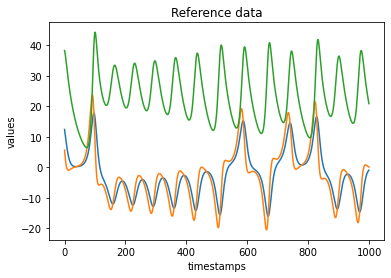

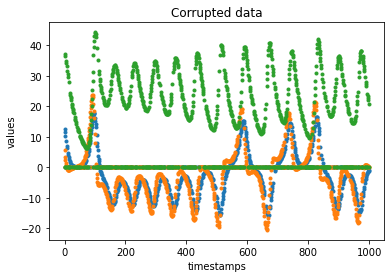

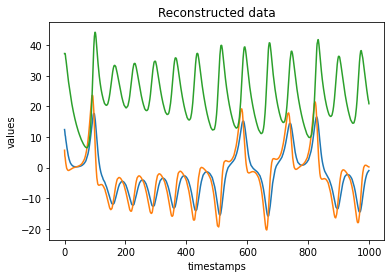

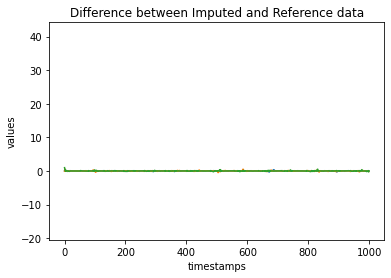

In [8]:
from matplotlib import pyplot as plt
# Reference data
plt.title("Reference data")
plt.xlabel("timestamps")
plt.ylabel("values")
plt.plot(dense_mat.T)
plt.show()
# Corrupted data
plt.title("Corrupted data")
plt.xlabel("timestamps")
plt.ylabel("values")
plt.plot(sparse_mat.T,'.')
plt.show()
# Imputed data
plt.title("Reconstructed data")
plt.xlabel("timestamps")
plt.ylabel("values")
plt.plot(result.T)
plt.show()
# Difference between Imputed and Reference data
plt.title("Difference between Imputed and Reference data")
plt.xlabel("timestamps")
plt.ylabel("values")
plt.plot((dense_mat - result).T)
plt.ylim([np.min(dense_mat), np.max(dense_mat)])
plt.show()